# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [30]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches).

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [31]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [32]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [33]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
g = autograd.grad
print(g(f,0)(0.0,0.0))

1.0


In [34]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [35]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed",
        levels=levels
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [36]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y

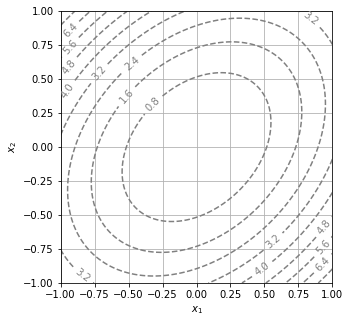

In [37]:
display_contour(
    f1,
    x=np.linspace(-1.0, 1.0, 100),
    y=np.linspace(-1.0, 1.0, 100),
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [38]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

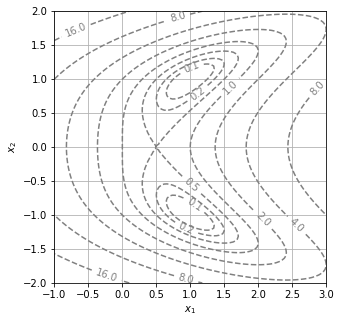

In [39]:
display_contour(
    f2,
    x=np.linspace(-1.0, 3.0, 100),
    y=np.linspace(-2.0, 2.0, 100),
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [40]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y)

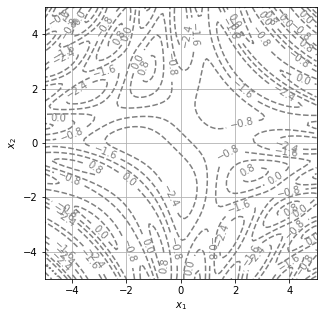

In [41]:
display_contour(
    f3,
    x=np.linspace(-5.0, 5.0, 100),
    y=np.linspace(-5.0, 5.0, 100),
    levels=5, # 5 levels, automatically selected
)

In [42]:
def f4(x,y):
    return x**2 + y**2

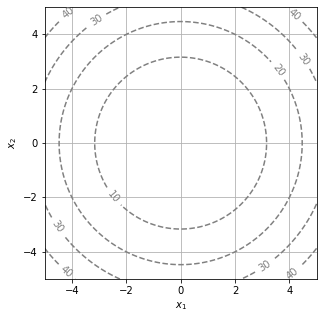

In [43]:
display_contour(
    f4,
    x=np.linspace(-5.0, 5.0, 100),
    y=np.linspace(-5.0, 5.0, 100),
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [44]:
N = 1_000
EPS = 10**(-3)

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [45]:
def Newton(F, x0, y0, eps = EPS, N = N):
    x, y = x0, y0
    for i in range(N):
        grad = np.dot(np.linalg.inv(J(F)(x, y)), F(x, y))
        #ou grad = np.linalg.solve(J(F)(x, y), F(x, y))
        x, y = np.array([x, y]) - grad
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

In [46]:
def f5(x, y):
    return np.array([f1(x, y) - 0.8, x - y])

Newton(f5, 0.8, 0.8)


(0.4472135970019964, 0.4472135970019964)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

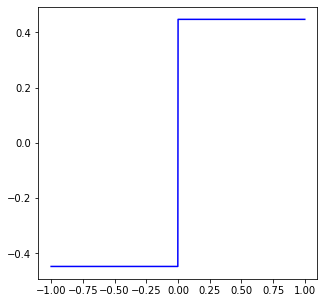

In [47]:
def repres_Newton(f):
    n = 1_000
    X = np.linspace(-1, 1, n)
    Newton_vect = np.vectorize(Newton)
    Y = Newton_vect(f, X, X)
    plt.plot(X, Y[0], 'b')
    plt.show()
    
repres_Newton(f5)

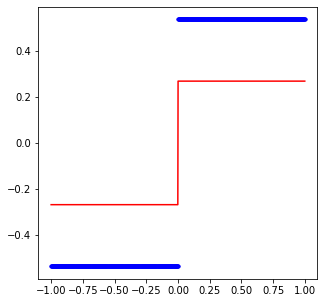

In [48]:
def f6(x,y):
    return np.array([f1(x,y) - 0.8, x - 2 * y])

n = 1_000
X = np.linspace(-1, 1, n)
X1 = [Newton(f6, X[k], X[k])[0] for k in range(n)]
X2 = [Newton(f6, X[k], X[k])[1] for k in range(n)]
plt.plot(X, X1, 'b.')
plt.plot(X, X2, 'r')
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [49]:
def level_curve(f, x0, y0, c, delta = 0.1, N = 1_000):
    x, y = x0, y0
    res = np.empty((2, N + 1))
    res[:,0] = np.array([x, y])
    mat_rot = np.array([[0., 1.], [-1., 0.]])
    grad_f = grad(f)
    for i in range(N):
        def F(x_, y_):
            return np.array([f(x_, y_) - c, (x_ - x)**2 + (y_ - y)**2 - delta**2])
        gradF = grad_f(x, y)
        vect_u = np.dot(mat_rot, gradF) / np.linalg.norm(gradF) * delta
        x_, y_ = np.array([x, y]) + vect_u
        x, y = Newton(F, x_, y_)
        res[::, i] = np.array([x, y])
    return res[::, :N]

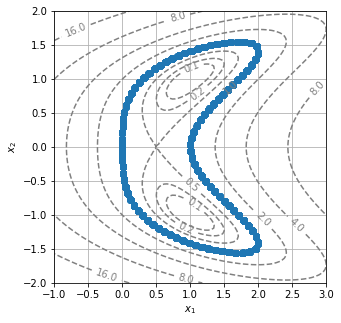

Y = 1000


In [50]:
X, Y = level_curve(f2, 0., 0., f2(0., 0.), N = 10000)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(X, Y, ':o')
plt.axis([-1, 3, -2, 2])
plt.show()

print(f"Y = {level_curve(f2, 0., 0., f2(0., 0.), N = 1000).shape[1]}")

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [51]:
def level_curve2(f, x0, y0, c, delta = 0.1, N = 1_000):
    x, y = x0, y0
    res = np.empty((2, N))
    res[:, 0] = np.array([x, y])
    mat_rot = np.array([[0., -1.], [1., 0.]])
    grad_f = grad(f)
    for i in range(N - 1):
        def F(x_, y_):
            return np.array([f(x_, y_) - c, (x_ - x)**2 + (y_ - y)**2 - delta**2])
        gradF = grad_f(x, y)
        vect_u = np.dot(mat_rot, gradF) / np.linalg.norm(gradF) * delta
        x_, y_ = np.array([x, y]) + vect_u
        x, y = Newton(F, x_, y_)
        res[::, i] = np.array([x, y])
        if i > N // 10: #on s'écarte du point de départ
            if (x0 - x)**2+(y0 - y)**2 < delta: #si on est revenu vers le point de départ
                return res[::, :i]
    return res

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

In [52]:
def repres_level_curve(f, x0, y0, c, M = 1_000):
    X, Y = level_curve(f, x0, y0, c, N = M)
    plt.plot(X, Y, 'r:o')
    plt.show()



def repres_level_curve2(f, x0, y0, c, M = 1_000):
    X, Y = level_curve2(f, x0, y0, c, N = M)
    plt.plot(X, Y, 'r:o')
    plt.show()

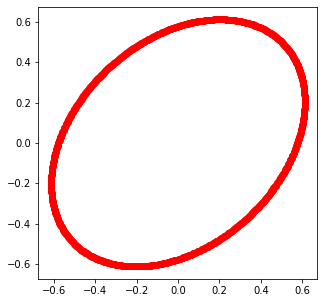

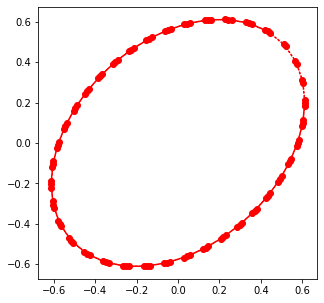

In [53]:
#Avec f1

repres_level_curve(f1, 0.5, 0.5, 1.)
repres_level_curve2(f1, 0.5, 0.5, 1.)

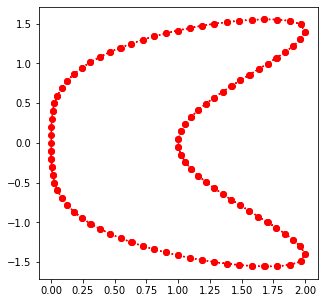

In [54]:
#Avec f2
repres_level_curve2(f2, 0., 0., f2(0., 0.))

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [55]:
def area_squares(f, c, h):
    def F(x, y):
        return np.array([f(x, y) - c, x - y])
    x0, y0 = Newton(F, 1., 1.) #on cherche un point de départ pour level_curve
    tab = level_curve2(f, x0, y0, f(x0, y0))
    x, y = (np.min(tab[0]), np.max(tab[1])) #point en haut à gauche, repère pour dessiner le carre
    L = max(np.max(tab[0]) - np.min(tab[0]), np.max(tab[1]) - np.min(tab[1])) #cote du carre
    N = int(L / h)
    Ah = 0
    for i in range(N):
        for j in range(N):
            if f(x + (i + 0.5) * h, y - (j + 0.5) * h) <= c: #on teste le centre de chaque carre
                Ah += 1
    return Ah * (h**2)

On constate bien que pour h tendant vers 0, i.e. log(h) tendant vers -inf, 
l'erreur tend aussi vers O


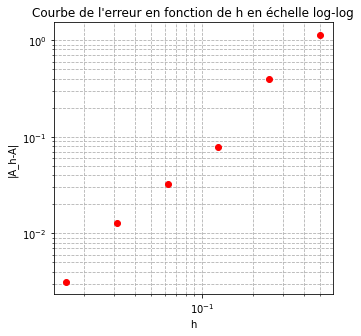

In [56]:
def norme(x, y):
    return np.sqrt(x**2 + y**2)

X = [2**(-i) for i in range(1, 7)]
Y = [np.abs(area_squares(norme, 1., x) - np.pi) for x in X]
plt.loglog(X, Y, 'ro')
plt.grid(True, which = "both", linestyle = '--')
plt.title("Courbe de l'erreur en fonction de h en échelle log-log")
plt.xlabel("h")
plt.ylabel("|A_h-A|")
plt.plot()
print("On constate bien que pour h tendant vers 0, i.e. log(h) tendant vers -inf, \nl'erreur tend aussi vers 0")

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [57]:
def area_squares_encadrement(f, c, h):
    """
    on s'inspire de l'approximation des intégrales par la méthode des rectangles : 
    on applique area_squares en regardant si tous les côtés du carré sont sous la ligne de niveau pour une minoration
    et en regardant si un seul côté du carré soit sous la ligne de niveau pour le comptabiliser pour une majoration
    """
    def F(x, y):
        return np.array([f(x, y) - c, x - y])
    
    x0, y0 = Newton(F, 1., 1.) #on cherche un point de départ pour level_curve
    tab = level_curve(f, x0, y0, f(x0, y0))
    x, y = (np.min(tab[0]), np.max(tab[1])) #point en haut à gauche, repère pour dessiner le carre
    L = max(np.max(tab[0]) - np.min(tab[0]), np.max(tab[1]) - np.min(tab[1])) #cote du carre
    N = int(L / h)
    A_min = 0
    A_max = 0
    
    for i in range(N - 1):
        for j in range(N - 1):
            
            # Pour minorer, on vérifie que TOUS les côtés du carré sont sous la ligne de niveau 
            if (f(x + i * h, y - j * h) <= c) and (f(x + (i + 1) * h, y - j * h) <= c) and (f(x + (i + 1) * h, y - (j + 1) * h) <= c) and (f(x + i * h, y - (j + 1) * h) <= c):
                A_min += h**2
           
            # Pour majorer, il suffit qu'un seul côté du carré soit sous la ligne de niveau pour le comptabiliser
            if (f(x + i * h, y - j * h) <= c) or (f(x + (i + 1) * h, y - j * h) <= c) or (f(x + (i + 1) * h, y - (j + 1) * h) <= c) or (f(x + i * h, y - (j + 1) * h) <= c):
                A_max += h**2
            
    return A_min, A_max



def area_squares_precision(f, c, prec):
    h = 0.5
    A_min, A_max = area_squares_encadrement(f, c, h)
    while A_max - A_min > prec:
        h /= 5
        A_min, A_max = area_squares_encadrement(f, c, h)
    print(f"On a l'encadrement suivant : {A_min} < area < {A_max}")
    
area_squares_precision(norme, 1., 10**(-2))

On a l'encadrement suivant : 3.1381785603527885 < area < 3.1443814403538277


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [58]:
def aire_T(A, B, C):
    """
    Aire du triangle ABC = 1/2 module(vect(AB) ^ vect(AC))
    """
    mat = [[A[0], A[1], 1], [B[0], B[1], 1], [C[0], C[1], 1]]
    return np.linalg.det(mat) / 2
    
    
    
    
def aire_triangles(p, frontiere_K):
    """
    on somme l'aire de chaque triangle pour obtenir une approximation de l'aire de K
    """
    B_N = aire_T(p, frontiere_K[::, -1], frontiere_K[::, 0])
    for i in range(len(frontiere_K[0]) - 1):
        B_N += aire_T(p, frontiere_K[::, i], frontiere_K[::, i + 1])
    return abs(B_N)

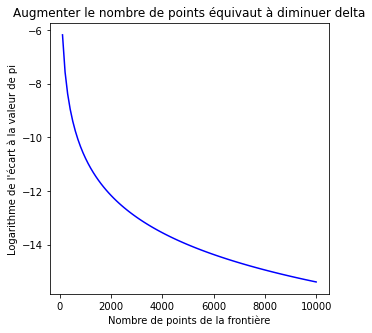

In [59]:
def frontiere(N):
    """
    Calcule N points équirépartis sur le cercle unité
    """
    return np.array(
        [np.array([np.cos(2 * np.pi * k / N) for k in range(N)]),
         np.array([np.sin(2 * np.pi * k / N) for k in range(N)])]
        )
  
    
    
X = np.linspace(100, 10**4, 100)
Y = [np.log(np.abs(aire_triangles((0.,0.), frontiere(int(x))) - np.pi)) for x in X]
plt.plot(X, Y, 'b')
plt.xlabel("Nombre de points de la frontière")
plt.ylabel("Logarithme de l'écart à la valeur de pi")
plt.title("Augmenter le nombre de points équivaut à diminuer delta")
plt.show()


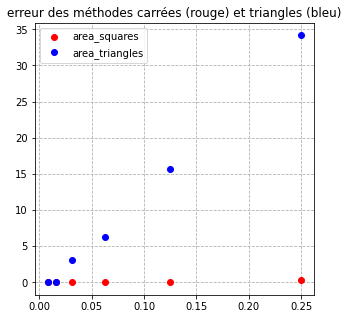

In [60]:
for i in range (2, 7): 
    plt.plot(2**(-i), np.abs(np.pi - area_squares(norme, 1., 2**(-i))), 'ro')
    plt.plot(2**(-i), np.abs(np.pi - aire_triangles((0., 0.), level_curve2(norme, 0., 1., 1., delta = 2**(-i), N = 3_000))), 'bo')

plt.grid(True, which = "both", linestyle = '--')

plt.title('erreur des méthodes carrées (rouge) et triangles (bleu)')
plt.plot(2**(-7), np.abs(np.pi - area_squares(norme, 1., 2**(-i))), 'ro', label = 'area_squares')
plt.plot(2**(-7), np.abs(np.pi - aire_triangles((0., 0.), level_curve2(norme, 0., 1., 1., delta = 2**(-i), N = 3_000))), 'bo', label = 'area_triangles')
plt.legend()
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [61]:
"""
Le déterminant prend en compte le sens des points du triangle.
Calculer l'aire d'un ensemble revient à calculer une intégrale, c'est-à-dire une somme
d'aires infinitésimales comptées positivement ou négativement.
En prenant comme point de départ un point extérieur à K, l'aire "en trop" comptées dans
les triangles dont les sommets sont dans le sens trigonométrique est compensée par les aires
négatives des triangles dont les sommets sont dans le sens anti-trigonométrique.
"""
aire_triangles((2., 2.), frontiere(1000))

3.1415719827794732

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [62]:
"""
on vérifie dans le cas d'une somme de deux disques disjoints qu'on retrouve la bonne aire
"""

N = 100
disque_1 = frontiere(N)
disque_2 = disque_1 + 4. * np.ones((2, N))
p = (2., 2.)
print(
    f"Somme de deux disques disjoints de rayon 1 = {aire_triangles(p, disque_1) + aire_triangles(p, disque_2)}, \n 2pi = {2 * np.pi}"
)


Somme de deux disques disjoints de rayon 1 = 6.279051952931339, 
 2pi = 6.283185307179586


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [63]:
def area_triangles(x, y):
    front = np.empty((2, len(x)))
    front[0, ::] = x
    front[1, ::] = y
    return aire_triangles((0., 0.), front)




area_triangles(
    level_curve2(f1, 0., -0.5, f1(0., -0.5), delta = 0.001, N = 10_000)[0, ::],
    level_curve2(f1, 0., -0.5, f1(0., -0.5), delta = 0.001, N = 10_000)[1, ::]
    )

0.8330352082890407